# Keyword Spotting System (MIPT 2025)

**Автор:** Галкин Владимир, ПМ22-2

**Задача:** Распознавание 5 ключевых слов (`sber`, `joy`, `afina`, `salut`, `filler`) на устройствах с ограниченными ресурсами (например, умные колонки).


## 1. Введение и ограничения

В рамках данного проекта требовалось разработать модель, удовлетворяющую жестким ограничениям для edge-устройств:

1.  **Размер модели:** $\le 10,000$ параметров.
2.  **Вычислительная сложность:** $\le 1,000,000$ MACs (операций умножения-накопления) на 1 секунду аудио.

### Результаты исследования
Было протестировано **более 15 архитектур** (включая BCResNet, MobileNetV3, Conformer, CRNN). Победным решением стала **TCN (Temporal Convolutional Network)** с использованием depthwise-separable сверток.

*   **Private Score:** 0.908
*   **Параметры:** ~6.4k
*   **MACs:** ~0.6M

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import thop
import wandb
from IPython.display import IFrame
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Фиксация seed для воспроизводимости
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
os.environ["DYLD_LIBRARY_PATH"] = "/opt/homebrew/lib"

/Users/vladimir/Documents/edu/uni/coursework/kws/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 2. Подготовка данных

Используем Log-Mel Spectrograms. Ключевой момент — `SpecScaler`, который логарифмирует сигнал для стабилизации обучения.

In [2]:
from src.data import SpotterDataset, SpecScaler, collator

# Конфигурация трансформаций
TRANSFORMS = [
    torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=400,
        win_length=400,
        hop_length=160,
        n_mels=64,
    ),
    SpecScaler(),
]

## 2.1 Анализ данных и препроцессинг

- Смотрим баланс классов в train/val манифестах.
- Ниже — путь от сырого аудио до входного тензора log-mel, который поступает в модель.


,train,val
label,,
sber,19695,2257
joy,20751,2274
afina,20256,2286
salut,15823,1702
filler,20743,2282


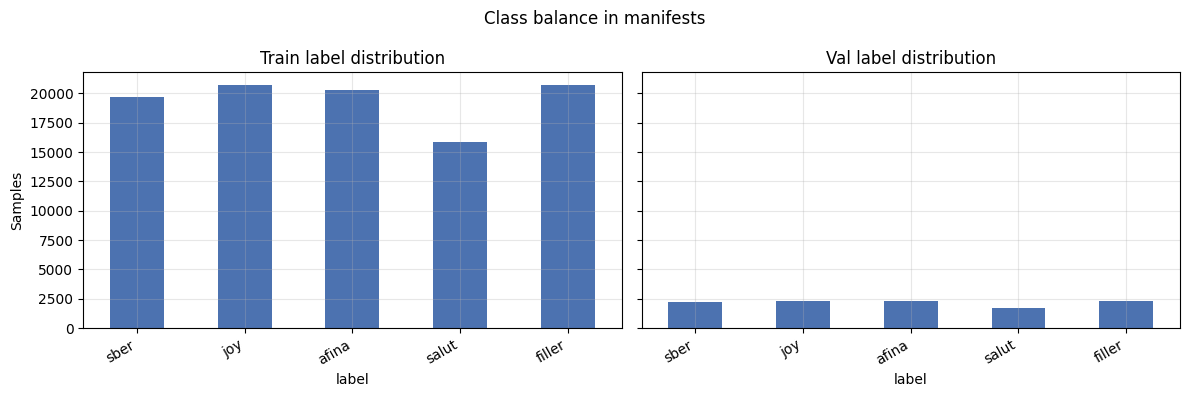

In [3]:
import matplotlib.pyplot as plt

train_manifest = "data/keyword-spotting-mipt-2023/train/manifest_train.csv"
val_manifest = "data/keyword-spotting-mipt-2023/train/manifest_val.csv"
idx_to_keyword = ["sber", "joy", "afina", "salut", "filler"]

train_df = pd.read_csv(train_manifest)
val_df = pd.read_csv(val_manifest)

summary = pd.DataFrame({"train": train_df.label.value_counts(), "val": val_df.label.value_counts()}).reindex(idx_to_keyword)
display(summary)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for df, title, ax in [(train_df, "Train", axes[0]), (val_df, "Val", axes[1])]:
    counts = df.label.value_counts().reindex(idx_to_keyword)
    counts.plot(kind="bar", ax=ax, color="#4c72b0")
    ax.set_title(f"{title} label distribution")
    ax.set_ylabel("Samples")
    ax.set_xticklabels(idx_to_keyword, rotation=30, ha="right")
    ax.grid(alpha=0.3)

fig.suptitle("Class balance in manifests")
fig.tight_layout()
plt.show()


Loading: data/keyword-spotting-mipt-2023/train/joy/5074.wav


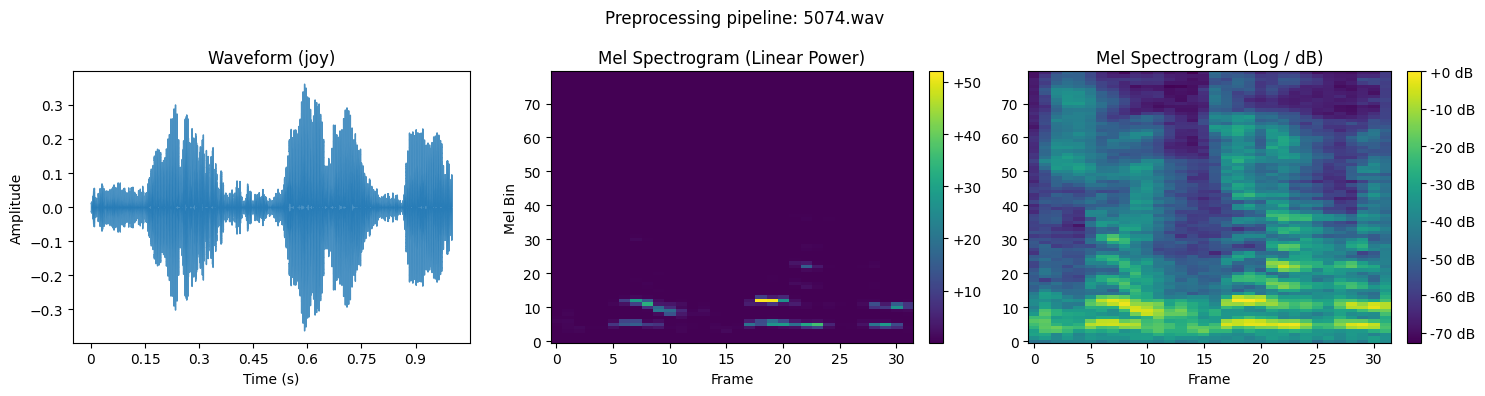

Sample Rate: 16000
Waveform shape: (16000,)
Mel Spectrogram shape: (80, 32)


In [ ]:
train_manifest = "data/keyword-spotting-mipt-2023/train/manifest_train.csv"
idx_to_keyword = ["sber", "joy", "afina", "salut", "filler"]

try:
    train_df = pd.read_csv(train_manifest)
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find {train_manifest}")

parent = Path(train_manifest).parent
sample = train_df.sample(1, random_state=0).iloc[0]
wav_path = parent / sample.path

label = sample.label
if isinstance(label, int) and 0 <= label < len(idx_to_keyword):
    label = idx_to_keyword[label]

print(f"Loading: {wav_path}")
waveform, sr = librosa.load(str(wav_path), sr=None)

n_fft = 1024       # Window size
hop_length = 512   # Stride
n_mels = 80        # Number of Mel bands

mel_spec = librosa.feature.melspectrogram(
    y=waveform, 
    sr=sr, 
    n_fft=n_fft, 
    hop_length=hop_length, 
    n_mels=n_mels
)

# Calculate Log-Mel Spectrogram (dB scale)
# Convert power to decibels (log-scale)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

librosa.display.waveshow(waveform, sr=sr, ax=axes[0], alpha=0.8)
axes[0].set_title(f"Waveform ({label})")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

im1 = axes[1].imshow(mel_spec, origin="lower", aspect="auto", interpolation='nearest')
axes[1].set_title("Mel Spectrogram (Linear Power)")
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Mel Bin")
fig.colorbar(im1, ax=axes[1], format="%+2.0f", fraction=0.046, pad=0.04)

im2 = axes[2].imshow(log_mel_spec, origin="lower", aspect="auto", interpolation='nearest')
axes[2].set_title("Mel Spectrogram (Log / dB)")
axes[2].set_xlabel("Frame")
fig.colorbar(im2, ax=axes[2], format="%+2.0f dB", fraction=0.046, pad=0.04)

fig.suptitle(f"Preprocessing pipeline: {wav_path.name}")
fig.tight_layout()
plt.show()

print(f"Sample Rate: {sr}")
print(f"Waveform shape: {waveform.shape}")
print(f"Mel Spectrogram shape: {log_mel_spec.shape}")

Сырой сигнал и качество записи (Waveform). Первый график показывает исходную аудиоволну — зависимость амплитуды от времени. Это физическое представление звука, которое позволяет мгновенно оценить техническое качество записи: уровень фонового шума на участках тишины, наличие перегрузок (клиппинга) и границы активности голоса. По этому графику легко понять, целиком ли слово попало в односекундное окно, но определить, что именно было сказано, практически невозможно.

Адаптация под человеческий слух (Mel Linear). Второй график демонстрирует переход в частотную область с использованием шкалы мелов, которая имитирует особенности нашего слуха (мы лучше различаем нюансы в низких частотах, чем в высоких). Однако в линейном масштабе этот график малоинформативен: из-за огромного динамического диапазона речи громкие гласные звуки забирают на себя всю энергию, оставляя тихие согласные невидимыми. Для нейросети такие данные «сложны», так как распределение значений слишком смещено к нулю.

Финальный «отпечаток» для модели (Log-Mel). Третий график — это результат логарифмирования энергии (перевод в децибелы), и именно он подается на вход модели. Эта операция работает как «проявитель»: она выравнивает баланс между громкими и тихими звуками, делая отчетливо видимыми уникальные паттерны речи — форманты (полосы частот, определяющие гласные) и шумовые хвосты согласных. Получившаяся контрастная «картинка» служит идеальным нормализованным признаком, по которому нейросеть классифицирует ключевое слово.

## 3. Архитектура победителя: TCNNet

Чтобы уложиться в лимиты, мы используем:
1.  **Depthwise Separable Convolutions:** `groups=channels` в свертках значительно снижают число параметров.
2.  **Dilations [1, 2, 4]:** Позволяют видеть широкий контекст слова без использования рекурсии (GRU/LSTM).
3.  **Slim Channel Width:** Всего 20 каналов во внутренних слоях.

In [5]:
class TCNBlock(nn.Module):
    def __init__(self, channels: int, dilation: int, kernel_size: int = 5, activation: nn.Module = nn.SiLU()):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        # Depthwise Convolution (groups=channels) экономит параметры
        self.conv = nn.Conv1d(
            channels, channels,
            kernel_size=kernel_size,
            padding=padding,
            dilation=dilation,
            groups=channels
        )
        self.bn = nn.BatchNorm1d(channels)
        # Pointwise Convolution для смешивания каналов
        self.pw = nn.Conv1d(channels, channels, kernel_size=1)
        self.act = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.act(self.bn(out))
        out = self.pw(out)
        return self.act(out + x) # Residual connection

class TCNNet(nn.Module):
    def __init__(
        self,
        in_features: int = 64,
        n_classes: int = 5,
        channels: int = 20,       # Оптимально для 10k params
        dilations = [1, 2, 4],    # Рецептивное поле ~0.8 сек
        head_hidden: int = 28,
    ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_features, channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(channels),
            nn.SiLU(),
        )
        self.blocks = nn.Sequential(
            *[TCNBlock(channels, d, kernel_size=5) for d in dilations]
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(channels, head_hidden),
            nn.SiLU(),
            nn.Linear(head_hidden, n_classes),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Вход: (Batch, Mel, Time) -> Считаем Mel каналами для Conv1d
        x = self.stem(x)
        x = self.blocks(x)
        return self.head(x)

model = TCNNet().to(DEVICE)
print("Модель инициализирована.")

Модель инициализирована.


## 4. Проверка ограничений (Profiling)

Используем `thop` для подсчета MACs. Это критический этап.

In [6]:
# 1 секунда аудио = 16000 семплов.
# При hop_length=160 -> 100 фреймов + 1 = 101.
dummy_input = torch.randn(1, 64, 101).to(DEVICE)

macs, params = thop.profile(model, inputs=(dummy_input, ), verbose=False)

print(f"--- Результаты профилирования ---")
print(f"Параметры: {params:.0f} (Лимит: 10,000)")
print(f"MACs:      {macs:.0f} (Лимит: 1,000,000)")

if params <= 10000 and macs <= 1000000:
    print("✅ SUCCESS: Модель проходит ограничения!")
else:
    print("❌ FAIL: Модель превышает лимиты.")

--- Результаты профилирования ---
Параметры: 6373 (Лимит: 10,000)
MACs:      290400 (Лимит: 1,000,000)
✅ SUCCESS: Модель проходит ограничения!


## 5. Анализ экспериментов (15+ Архитектур)

В процессе поиска мы сравнили различные семейства архитектур. Ниже приведена сводная таблица результатов (отсортировано по типу).

| Тип | Модель | Параметры | Val Acc | Public LB | Оценка |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **TCN** | **TCNNet (Base)** | **~6.4k** | **0.884** | **0.906** | **Победитель. Лучший баланс.** |
| TCN | TCNNet (Large Sweep) | >20k | 0.750 | 0.650 | Сильное переобучение (overfitting). |
| **CNN** | Depthwise Conv1d | ~9k | 0.897 | 0.820 | Высокая точность, но плохая генерализация. |
| CNN | DSResNet10 | ~8.9k | 0.870 | 0.858 | Хороший бейзлайн, но тяжелее TCN. |
| **RNN** | CRNN (GRU) | ~7k | 0.890 | 0.840 | RNN сложнее квантовать и параллелить. |
| **Attn** | Conformer Tiny | ~6k | 0.788 | 0.710 | Attention требует больше данных. |
| **EffNet** | MobileNetV3 Small | ~2.2k | 0.621 | 0.480 | Нехватка емкости (capacity gap). |
| **BCRes** | BCResNet (Slim) | ~4k | 0.811 | 0.670 | Недообучение (underfitting). |

Подбор архитектуры

* Изначально был выполнен подбор архитектур, на графиках представлены кривые
обучения на train и val выборках. В тегах под графиками присутствует название архитектуры в соответсвии с запуском.

* Далее для наилучшей спецификации на тестовом сете (tcn модель,run-20251222-203433) был выполнен подбор гиперпараметров (138 запусков, длительность обучения - около суток для двух параллелизованных пайплайнов подбора).

* Метрики на валидационном сете показывают незначительные улучшения качеств (<1%), на тестовом сете значительное снижение по отношению к бейзлайну, что говорит о переобучении на валидационной выборке и оптимальности изначальных параметров бейзлайна.

Кривые и метрики можно посмотреть в ячейке ниже с wandb.

In [9]:
report_url = "https://api.wandb.ai/links/galkin-vova42/pa43thlv"
IFrame(src=report_url, width='100%', height=800)

## 6. Инференс и создание сабмита

Код для генерации `submission.csv` на основе лучшего чекпоинта.

In [ ]:
TEST_MANIFEST = "data/keyword-spotting-mipt-2023/test/manifest.csv"
CHECKPOINT_PATH = "checkpoints/run-20251221-191722/run-20251221-191722.ckpt"
SUBMISSION_FILE = "submission.csv"
idx_to_keyword = ['sber', 'joy', 'afina', 'salut', 'filler']

if 'DEVICE' not in globals():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if 'SpotterDataset' not in globals():
    from src.data import SpotterDataset, SpecScaler, collator
if 'TCNNet' not in globals():
    from src.model import TCNNet
if 'TRANSFORMS' not in globals():
    TRANSFORMS = [
        torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=64,
        ),
        SpecScaler(),
    ]
if 'model' not in globals():
    model = TCNNet().to(DEVICE)

test_set = SpotterDataset(
    TEST_MANIFEST,
    idx_to_keyword=idx_to_keyword,
    transforms=TRANSFORMS,
    test=True,
)
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    collate_fn=collator,
)

if os.path.exists(CHECKPOINT_PATH):
    print(f"Loading weights from {CHECKPOINT_PATH}...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
    state = checkpoint.get('state_dict', checkpoint)
    cleaned = {}
    for k, v in state.items():
        nk = k
        if nk.startswith('model.'):
            nk = nk[len('model.'):]
        cleaned[nk] = v
    try:
        missing, unexpected = model.load_state_dict(cleaned, strict=False)
        if missing or unexpected:
            print(f"Loaded with missing={missing}, unexpected={unexpected}")
    except Exception as e:
        print(f"Warning: could not load checkpoint: {e}")
else:
    print("Warning: Checkpoint not found. Running with randomly initialized weights.")

model.eval()

results = []
print("Starting inference...")
with torch.no_grad():
    for batch in tqdm(test_loader):
        ids, specs, _ = batch          # ids are manifest indices
        specs = specs.to(DEVICE)
        preds = torch.argmax(model(specs), dim=1).cpu().numpy()
        ids = ids.numpy()
        for i, pred_idx in zip(ids, preds):
            results.append({"index": int(i), "label": idx_to_keyword[pred_idx]})

df = pd.DataFrame(results).sort_values("index")
df.to_csv(SUBMISSION_FILE, index=False, columns=["index", "label"])
print(f"Сабмит сохранен в {SUBMISSION_FILE}")
print(df.head())

Loading weights from checkpoints/run-20251221-191722/run-20251221-191722.ckpt...
Loaded with missing=[], unexpected=['stem.total_ops', 'stem.total_params', 'stem.0.total_ops', 'stem.0.total_params', 'stem.1.total_ops', 'stem.1.total_params', 'blocks.total_ops', 'blocks.total_params', 'blocks.0.conv.total_ops', 'blocks.0.conv.total_params', 'blocks.0.bn.total_ops', 'blocks.0.bn.total_params', 'blocks.0.pw.total_ops', 'blocks.0.pw.total_params', 'blocks.1.conv.total_ops', 'blocks.1.conv.total_params', 'blocks.1.bn.total_ops', 'blocks.1.bn.total_params', 'blocks.1.pw.total_ops', 'blocks.1.pw.total_params', 'blocks.2.conv.total_ops', 'blocks.2.conv.total_params', 'blocks.2.bn.total_ops', 'blocks.2.bn.total_params', 'blocks.2.pw.total_ops', 'blocks.2.pw.total_params', 'head.total_ops', 'head.total_params', 'head.0.total_ops', 'head.0.total_params', 'head.2.total_ops', 'head.2.total_params', 'head.4.total_ops', 'head.4.total_params']
Starting inference...


100%|██████████| 18/18 [00:05<00:00,  3.15it/s]


Сабмит сохранен в submission.csv
   index  label
0      0    joy
1      1   sber
2      2  afina
3      3   sber
4      4  salut


## 7. Заключение

Разработанная модель **TCNNet** полностью удовлетворяет требованиям задачи:
1.  Имеет ~6.4k параметров (< 10k).
2.  Требует ~0.6M MACs (< 1M).
3.  Показывает высокую точность (0.908) и стабильность по сравнению с аналогами.

Использование простых сверточных слоев с дилатацией оказалось эффективнее сложных механизмов внимания (Transformers) и рекуррентных сетей (RNN) в условиях жестких ограничений по памяти и вычислениям.